In [1]:
import matplotlib.pyplot as plt
import numpy as np
import re
from collections import defaultdict
from typing import LiteralString, Sequence

In [2]:
sample_idxes = set([41905, 7296, 1639, 48598, 18024, 16049, 14628,
                9144, 48265, 6717, 44348, 48540, 58469, 35741])

In [3]:
def extract_log(files:list[LiteralString]):
    # Regular expression to capture sample number and checking done time
    sample_no_pattern = r"for sample (\d+)"
    time_pattern = r"time (\d+\.\d+)"

    # Initialize empty dictionary
    sample_times:defaultdict[int,list[float]] = defaultdict(list)

    # Read each line of the log
    for file in files:
        id_seq = []
        time_seq = []
        with open(file, "r") as f:  # Replace "your_log_file.txt" with your actual filename
            for line in f:
                # Search for the pattern in the line
                match = re.search(sample_no_pattern, line)
                # If a match is found, extract sample number and checking done time
                if match:
                    sample_number = int(match.group(1))
                    id_seq.append(sample_number)
                    continue
                match = re.search(time_pattern, line)
                if match:
                    checking_time = float(match.group(1))
                    time_seq.append(checking_time)
        for id, time in zip(id_seq, time_seq):
            # Add the key-value pair to the dictionary
            sample_times[id].append(time)
            
        for timeouted_id in (sample_idxes - set(id_seq)):
            #Control timeouted samples.
            sample_times[timeouted_id].append(float("inf"))
            print(f"sample {timeouted_id} timeouted at file {file}.")

    # Print the extracted dictionary
    return sample_times

In [4]:
import math
from typing import Literal


def plot_files(files:list[LiteralString], title:str, xticks:Sequence[int], xlabel:str, ylabel:str, xtick_labels:list[str]=[]):
    times_dict = extract_log(files)
    times_array:np.ndarray[tuple[Literal[14],int], np._dtype[np.float_]] = np.array(list(times_dict.values()))
    times_array[times_array==float("inf")] = np.nan
    times_array = np.log10(times_array)
    for sample in times_array:
        plt.plot(range(1, len(xticks)+1), sample, alpha=0.18)
    plt.plot(range(1, len(xticks)+1), np.nanmean(times_array, axis=0))
    
    top = np.nanmax(times_array[times_array!=np.inf])
    bot = np.nanmin(times_array)
    height = top - bot
    
    plt.title(title)
    if xtick_labels:
        plt.xticks(xticks, labels=xtick_labels)
    else:
        plt.xticks(xticks)
    yticks = np.linspace(np.floor(bot), np.ceil(top), 5)
    plt.yticks(yticks, labels=[str(int(10**y)) for y in yticks])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    plt.ylim(bot - 0.15*height, top + 0.15*height)
    plt.show()

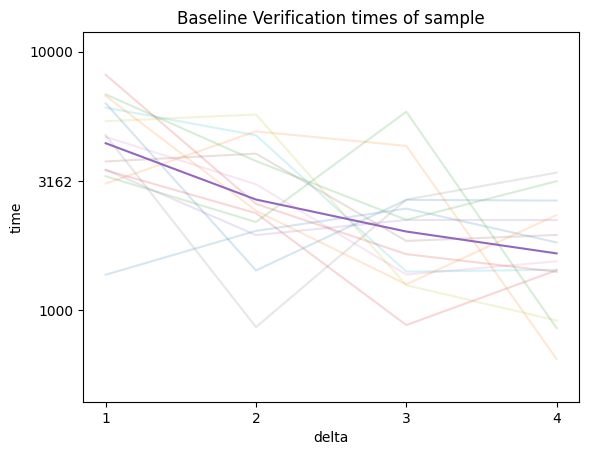

In [5]:
# from delta=1 to 4 in 5 step, 10 hidden rate baseline, with 14 samples
baseline_times_per_delta_files = """log/baseline_5_768_10_10.log
log/baseline_5_768_10_10_delta(2,).log
log/baseline_5_768_10_10_delta(3,).log
log/baseline_5_768_10_10_delta(4,).log""".split('\n')
plot_files(baseline_times_per_delta_files,
           "Baseline Verification times of sample",
           range(1, 5),
           "delta",
           "time")

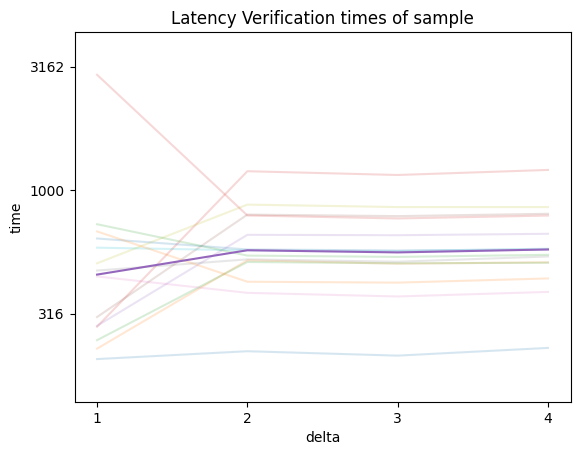

In [6]:
# from delta=1 to 4 in 5 step, 10 hidden rate baseline, with 14 samples
latency_times_per_delta_files = """log/05312233_mnist_latency_5_784_10_10.log log/06021902_mnist_latency_5_784_10_10_delta(2,).log log/06022018_mnist_latency_5_784_10_10_delta(3,).log log/06022018_mnist_latency_5_784_10_10_delta(4,).log""".split()
plot_files(latency_times_per_delta_files,
           "Latency Verification times of sample",
           range(1, 5),
           "delta",
           "time")

sample 16049 timeouted at file log/06021842_mnist_latency_7_784_14_10.log.


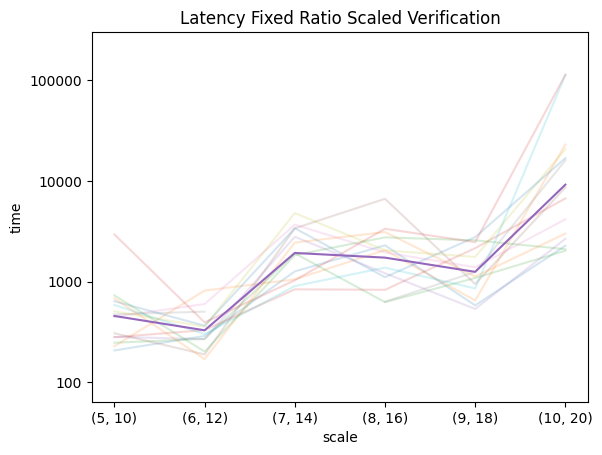

In [7]:
# delta = 1, fixed step/hidden ratio, increasing step, hidden.
files = """log/05312233_mnist_latency_5_784_10_10.log
log/06021842_mnist_latency_6_784_12_10.log
log/06021842_mnist_latency_7_784_14_10.log
log/06021843_mnist_latency_8_784_16_10.log
log/06021845_mnist_latency_9_784_18_10.log
log/06021845_mnist_latency_10_784_20_10.log""".split()
plot_files(files,
           "Latency Fixed Ratio Scaled Verification",
           range(1,6+1),
           "scale",
           "time",
           xtick_labels=[str(x) for x in zip(range(5,11),range(10,22,2))])

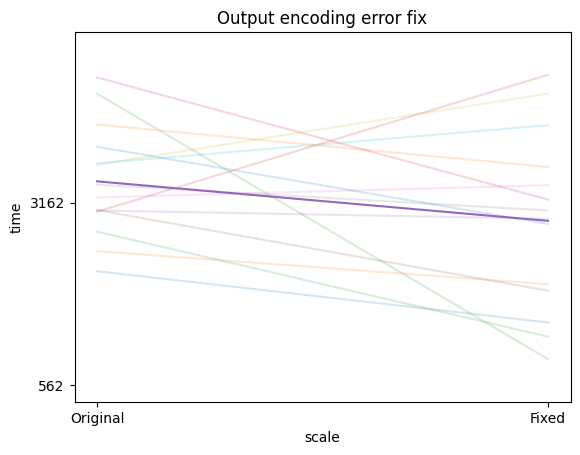

In [8]:
files = """log/06071233_baseline_5_784_10_10_delta_(1,).log log/06071307_baseline_5_784_10_10_delta_(1,).log""".split()
plot_files(files,
           "Output encoding error fix",
           range(1,2+1),
           "scale",
           "time",
           xtick_labels=["Original", "Fixed"])

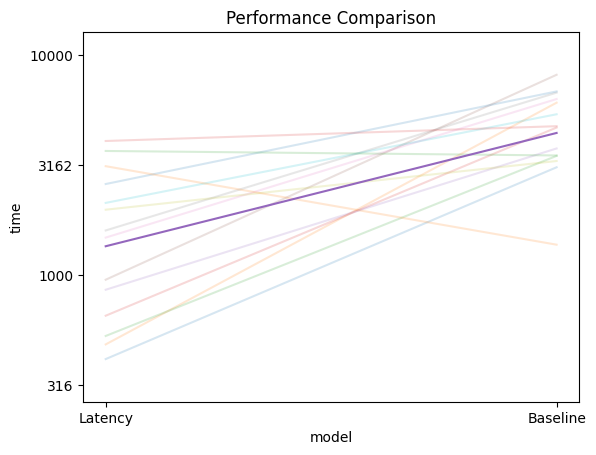

In [10]:
files = """log/06081404_mnist_latency_5_784_10_10_delta(1,).log log/baseline_5_768_10_10.log""".split()
plot_files(files,
           "Performance Comparison",
           range(1,2+1),
           "model",
           "time",
           xtick_labels=["Latency", "Baseline"])